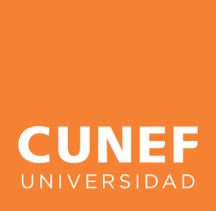
#  <font color=orange> Notebook: Clasificador Imágenes Melanoma</font>
## Máster en Ciencia de Datos
### Modelos de Inteligencia Artificial

<b> Profesor: </b> Wolfram Rozas
___________________________________________________________________________________________
__Resumen__


En este notebook desarrollamos problema de la clasificación _real_ de detección de lesiones de piel, e.g. un lunar, a partir de imágenes. El objetivo del problema de la Ciencia de Datos es determinar si la lesión es benigna o maligna. Se emplearán redes neuronales profundas convolucionales en su resolución

El proceso de análisis sigue los siguientes pasos:
<ol>
    <li>El Juego de Imágenes de Cáncel de Piel HAM10000</li>
    <li>Preparación de Datos</li>
    <li>Construcción y entrenamiento de una red neuronal no profunda</li>
    <li>Validacion del modelo. Mejora del entrenamiento</li>
    <li>La Clasificación con Redes Neuronales Convolucionales</li>
    <ol>
        <li>¿Qué es una Convolución?</li>
        <li>Compresión de Imágenes. El método Max Pooling</li>
        <li>Construcción de la Red Neuronal</li>
        <li>Visualización de los Filtros</li>
        <li>Predicciones con la red neuronal</li>
    </ol>
</ol>
___________________________________________________________________________________________

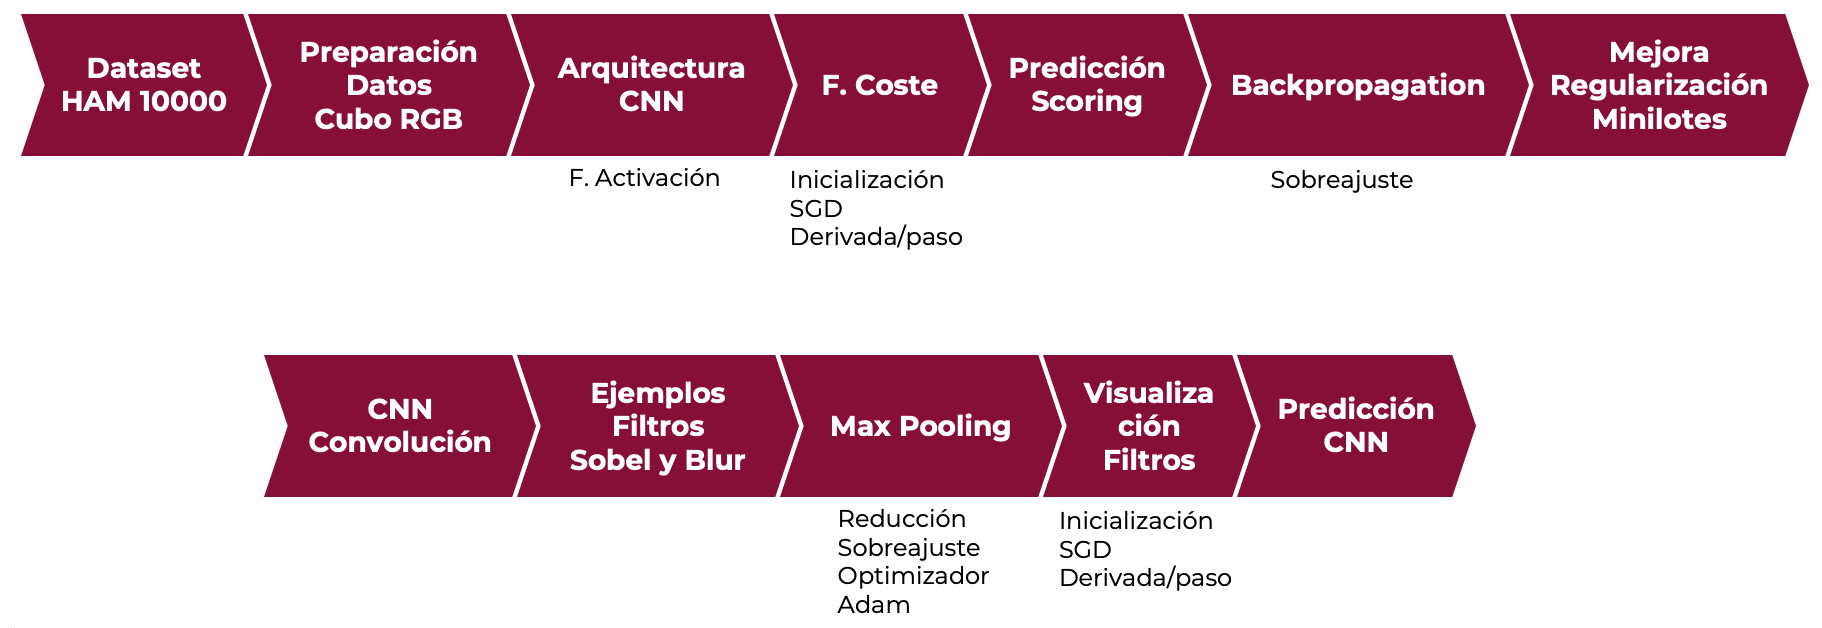

In [1]:
import numpy as np
import random
import pickle #Python object serialization¶

import pandas as pd
import torch

import matplotlib.pyplot as plt #librería gráfica
import seaborn as sns   #modelización y visualización

%matplotlib inline
import matplotlib as mpl
mpl.rc("figure", figsize=(16, 9))

In [2]:
def do_seeds(sn):
    np.random.seed(sn)
    torch.manual_seed(sn)
    random.seed(sn)
do_seeds(0)

Comenzamos comprobando si nuestra máquina dispone de GPU. En caso afirmativo, limpiamos el cache de la GPU

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if device == "cuda:0": torch.cuda.empty_cache()

cpu


In [4]:
torch.cuda.is_available()

False

# 1. El Juego de Imágenes de Cáncel de Piel HAM10000

Se entrenará el modelo con el juego de datos __HAM10000__ que contiene unas 10.000 imágenes de lesiones clasificadas según 10 categorías clínicas. 

Tschandl, Philipp, 2018, "The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions", https://doi.org/10.7910/DVN/DBW86T, Harvard Dataverse, V3, UNF:6:/APKSsDGVDhwPBWzsStU5A== [fileUNF]

Las imágenes son en color con una resolución media-alta (450 x 600) píxeles.

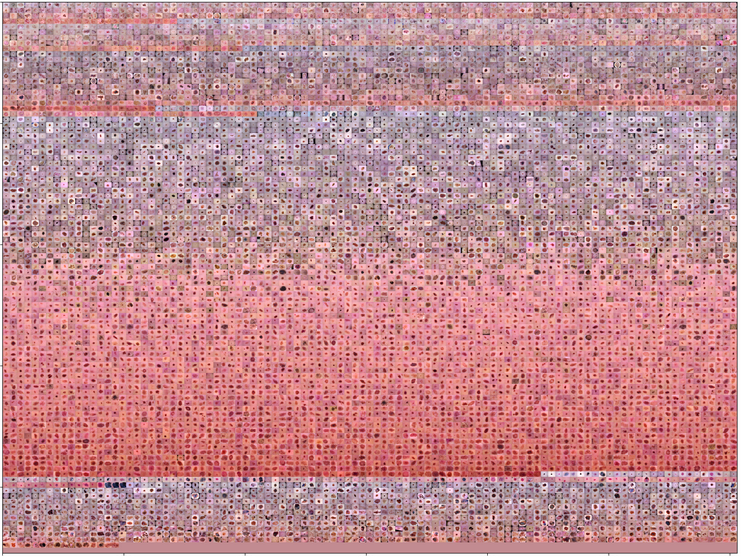

El objetivo del análisis se centrará en distinguir dos de las 10 clases de lesiones (las dos más habituales y difíciles de distinguir): los _melanocytic nevi_, benignos y los _melanomas_, malignos. Además, para hacer el problema más manejable en cuanto a tiempo de resolución, simplificaremos su resolución utilizando un juego de datos con la resolución reducida a (75 x 100) píxeles. El juego de datos reducido cuenta entonces con 2.000 imágenes en color, de (75 x 100) píxeles: 1.000 imágenes serán de la categoría _melanoma_ y las otras 1.000 de la categoría _melanocytic nevi_.


El juego de datos está disponible como fuente abierta en la página siguiente:
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T

Primero prepararemos los datos para el entrenamiento, después construiremos y entrenaremos una red neuronal básica no convolucional y analizaremos el comportamiento del modelo. Para mejorar nuestros resultados construiremos una red neuronal convolucional utilizando las capas convolucionales preconstruidas en Pytorch.

# 2. Preparación de los datos

Para preparar los datos seguimos los mismos pasos que para el entrenamiento de cualquier otro modelo: carga, separación, reescalado. El dataset reducido está guardado como un array de numpy en un archivo binario, que cargaremos con _pickle_.

El módulo pickle de Python implementa protocolos binarios para serializar y desserializar una estructura de objeto Python. "Pickling" (empaquetar) es el proceso mediante el cual una jerarquía de objetos de Python se convierte en un flujo de bytes (*byte stream*), y "unpickling" (desempaquetar) es la operación inversa, mediante la cual un byte stream (de un archivo binario o un objeto similar a bytes) se convierte de nuevo en una jerarquía de objetos.

In [5]:
from sklearn.model_selection import train_test_split

Cargamos los datos:

In [6]:
with open('ham_ss.dat', 'rb') as f:
    X_all, y_all = pickle.load(f)

In [7]:
print(X_all.shape) # 2000 imágenes, con 3 canales de color (R,G,B) y resolución 75x100
print(y_all.shape) # categorías de las imágenes: 1->maligno, 0->benigno

(2000, 3, 75, 100)
(2000,)


Los valores de las imágenes están guardados con precisión _uint8_ (número entero de 8 bits -entre 0 y 255-) para cada pixel y canal RGB (_red-green-blue_).

<img src="rgbcube.jpg" width="300">

<div style="text-align: center"> Cubo RGB </div>

Un cubo RGB tiene 255 x 255 x 255 = 16.581.375 colores

In [8]:
X_all[0,:,:,:] # Este tensor representa la primera imagen

array([[[103, 127, 134, ..., 117, 100,  73],
        [124, 150, 156, ..., 144, 128,  96],
        [131, 155, 159, ..., 153, 138, 106],
        ...,
        [107, 135, 150, ..., 113,  88,  56],
        [ 95, 123, 140, ...,  95,  68,  38],
        [ 73,  98, 113, ...,  67,  42,  20]],

       [[ 86, 105, 109, ..., 104,  87,  63],
        [105, 126, 130, ..., 129, 113,  84],
        [112, 132, 133, ..., 137, 123,  94],
        ...,
        [ 93, 118, 133, ...,  93,  70,  43],
        [ 82, 107, 124, ...,  77,  54,  28],
        [ 62,  85,  99, ...,  53,  33,  15]],

       [[ 88, 108, 113, ..., 112,  95,  69],
        [107, 130, 134, ..., 138, 122,  91],
        [112, 132, 136, ..., 147, 133, 102],
        ...,
        [ 90, 115, 132, ...,  96,  73,  48],
        [ 80, 105, 121, ...,  83,  60,  35],
        [ 63,  85,  98, ...,  60,  39,  21]]], dtype=uint8)

Podemos dibujar algunas imágenes con la librería de procesamiento de imágenes __skimage__

In [9]:
from skimage import io

/Users/wolframrozas/opt/anaconda3/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


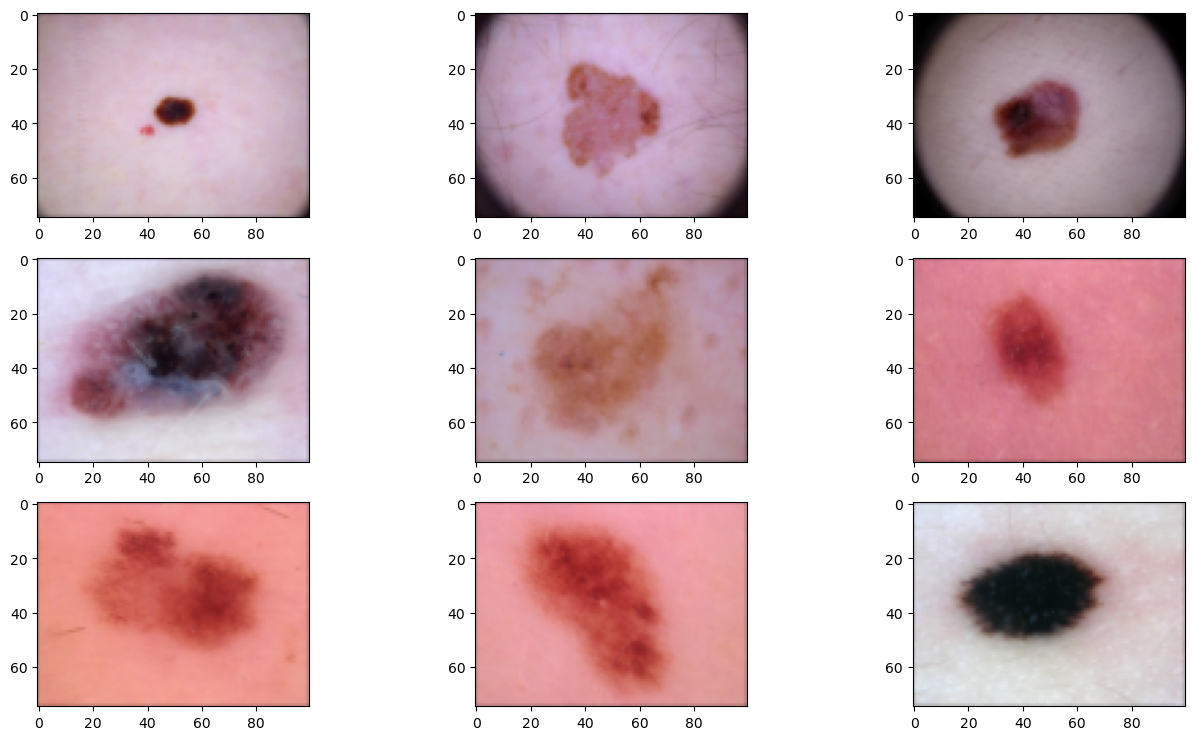

In [10]:
# Para dibujar las imágenes cambiamos las columnas de orden, 
# skimage espera el color en la última dimensión

ax = io.imshow_collection(np.transpose(X_all[::230,:,:,:], (0,2,3,1)))

# Scikit-image: librería de procesamiento de imágenes
# skimage.io.imshow_collection(ic, plugin=None, **plugin_args)[source]
#  Display a collection of images.
#   Parameters
#       icImageCollection
#           Collection to display.
#       pluginstr

#           Name of plugin to use. By default, the different plugins are tried until a suitable candidate is found.

#   Other Parameters

#       plugin_argskeywords
#           Passed to the given plugin.


In [11]:
print(y_all[::230])  #muestra cuáles son malignos (1) y cuáles benignos (0)

[1 1 1 1 1 0 0 0 0]


Al tratarse de datos que son píxeles, podemos reescalar directamente los datos al rango [-0.5,0.5], ya que sabemos que sus valores van de 0 a 255. Los valores de píxel son números enteros que van de 0 (negro) a 255 (blanco).

In [12]:
X_all_n = X_all / 255.0 - 0.5

Los datos no están particionados en entrenamiento y testing, así que tendremos que separarlos. Para que la separación esté equilibrada, haremos una separación estratificada. 80% del dataset será para entrenamiento (1.600 imágenes) y 20% para testing (400 imágenes).

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_all_n, y_all, stratify=y_all, test_size=0.2,
                                                     random_state=142, shuffle=True)

#  sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, 
#                                  random_state=None, shuffle=True, stratify=None)[source]

#    Split arrays or matrices into random train and test subsets

# 3. Construcción y entrenamiento de una red neuronal no profunda

Como primera aproximación al problema, probaremos a aplicar una red neuronal no convolucional directamente sobre los valores de los píxeles. El primer paso es cargar nuestras variables como tensor de Pytorch. Observamos que hemos definido __requires_grad__ como False, es decir, no se acarrean las derivadas

In [14]:
tX_train = torch.tensor(X_train, requires_grad=False, dtype=torch.float)
tX_test = torch.tensor(X_test, requires_grad=False, dtype=torch.float)
ty_train = torch.tensor(y_train, requires_grad=False, dtype=torch.long)  
ty_test = torch.tensor(y_test, requires_grad=False, dtype=torch.long)  

Cargamos los tensores con 1.600 imágenes de resolución 75 x 100 píxeles con 3 canales de color para training de imágenes; 400 imágenes de la misma resolución para test. También
cargamos un tensor que pueda recibir los 1.600 resultados en training y 400 en test.

In [15]:
tX_train.shape, tX_test.shape, ty_train.shape, ty_test.shape

(torch.Size([1600, 3, 75, 100]),
 torch.Size([400, 3, 75, 100]),
 torch.Size([1600]),
 torch.Size([400]))

## Arquitectura

Definimos una red neuronal que clasifique una imagen (valores de intensidad para cada color de cada pixel) en  lesión maligna o benigna. Nuestra capa de entrada tendrá tantas unidades (neuronas) como valores tengamos en cada imagen (3 x 75 x 100 = 22.500), y nuestra capa de salida tendrá los valores 1 (maligno) y 0 (benigno). La estructura de nuestra red será la misma que en el notebook anterior, con una única _hidden layer_ de 100 elementos. 

La arquitectura de nuestra red será la siguiente:

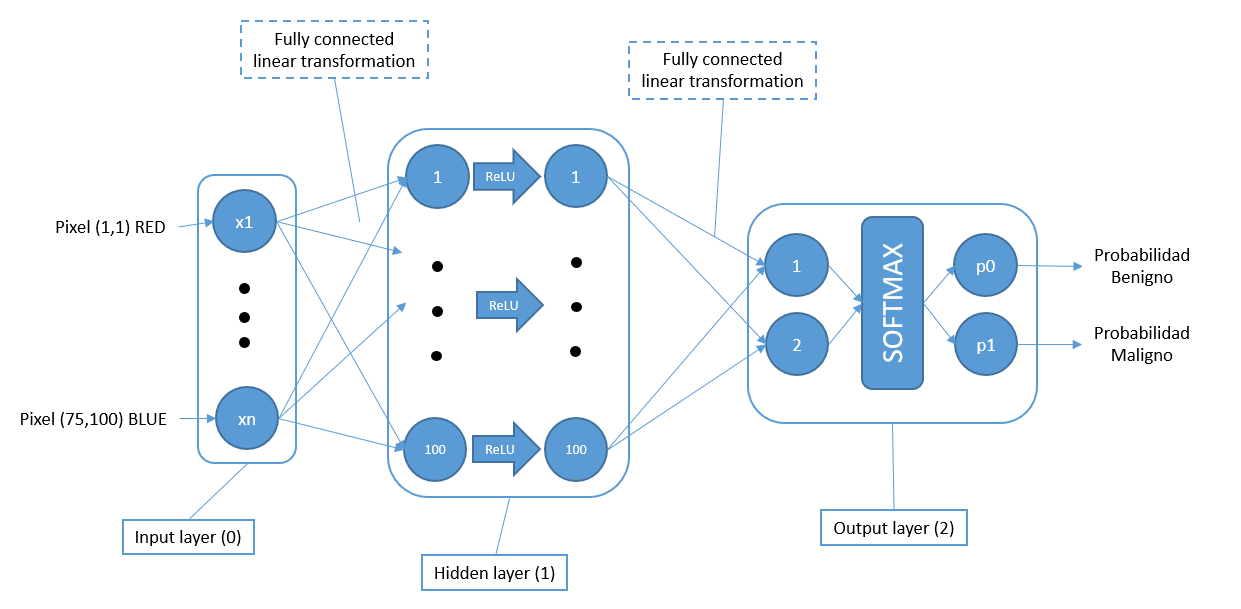

Para la función de activación de la capa 1 (la capa intermedia u oculta) utilizaremos la función ReLU:
 - $\mathrm{ReLU}(x) = \mathrm{max}(0, x)$

Como función de activación de la capa 2 (la de salida) utilizaremos la función Softmax, ya que queremos obtener probabilidades como salida de nuestra red y esta función reescala los inputs de forma que los outputs estén entre 0 y 1 y sumen 1:
- $\mathrm{Softmax}(x)_i = \frac{e^{x_i}}{\sum_j e^{x_j}}$


Construimos la red neuronal __nn1__ empleando las clases de Pytorch 'torch.nn.Sequential', 'torch.nn.ReLU', 'torch.nn.Linear' y 'torch.nn.LogSoftmax' que irán añadiendo capas a la red.

In [16]:
nn1 = torch.nn.Sequential(
    torch.nn.Linear(3*75*100, 100), # capa lineal con 22500 entradas y 100 salidas
    torch.nn.ReLU(),  # función de activación ReLU
    torch.nn.Linear(100, 2), # capa lineal con 100 entradas y 2 salidas
    torch.nn.LogSoftmax(dim=1) # función de activación LogSoftMax. 
    # El output es la probabilidad de pertenencia a cada categoría
)

Para que la propagación hacia adelante pueda aceptar los datos de entrada, primero tenemos que _aplanar_ (transformar los datos multidimensionales en monodimensionales) nuestro tensor de forma que los píxeles estén organizados en una única dimensión de 22.500 (3x75x100) elementos en lugar de 3 dimensiones de 3x75x100. Para ello podemos recurrir a la función __view__:

In [17]:
tX_train_l = tX_train.view(tX_train.shape[0], 22500)
tX_test_l = tX_test.view(tX_test.shape[0], 22500)

In [18]:
print(tX_train_l.shape)
print(tX_test_l.shape)

torch.Size([1600, 22500])
torch.Size([400, 22500])


La función __view__ ha aplanado los datos. Tenemos 1.600 fotos en el conjunto de entrenamiento y 400 en el conjunto de testing con 22.500 elementos cada una. 

Comprobamos que la propagación hacia adelante funciona con el conjunto de entrenamiento. Observamos que tiene la forma que esperamos, es decir, dos salidas (maligno/benigno) para cada una de las 1.600 fotos del conjunto 

In [19]:
nn1(tX_train_l).shape

torch.Size([1600, 2])

Para ejecutar los cálculos en la GPU movemos los tensores y _modules_ a la GPU:

In [20]:
nn1 = nn1.cuda()
tX_train_l = tX_train_l.cuda()
tX_test_l = tX_test_l.cuda()
tX_train = tX_train.cuda()
tX_test = tX_test.cuda()
ty_train = ty_train.cuda()
ty_test = ty_test.cuda()

AssertionError: Torch not compiled with CUDA enabled

## Inicialización de parámetros

La red que hemos construido tiene muchos mas parámetros que la empleada en el notebook
anterior. En estos casos hay que tener cuidado a la hora de inicializar los parámetros, ya que una mala inicialización puede dar lugar a inestabilidades numéricas que impedirían el entrenamiento. 

In [ ]:
for name, param in nn1.named_parameters():
    print(name, param.shape) 

In [ ]:
np.sum([np.prod(p.shape) for p in nn1.parameters()]) # Calcula el número de parámetros de la red neuronal
# el número de parámetros es:
# capa entrada: (100 x 22500) pesos + 100 sesgos
# capa salida: (2 x 100) pesos + 2 sesgos
# total = 2.250.302

Utilizaremos la inicialización __xavier__ (por Xavier Glorot) para rellenar los pesos. Se inicializa los parámetros con una distribución distinta en cada capa. Garantiza que los valores de las activaciones en cada neurona estén en rangos aceptables independientemente del número de inputs. Las redes inicializadas con Xavier consiguen una convergencia más rápida y mayor precisión.

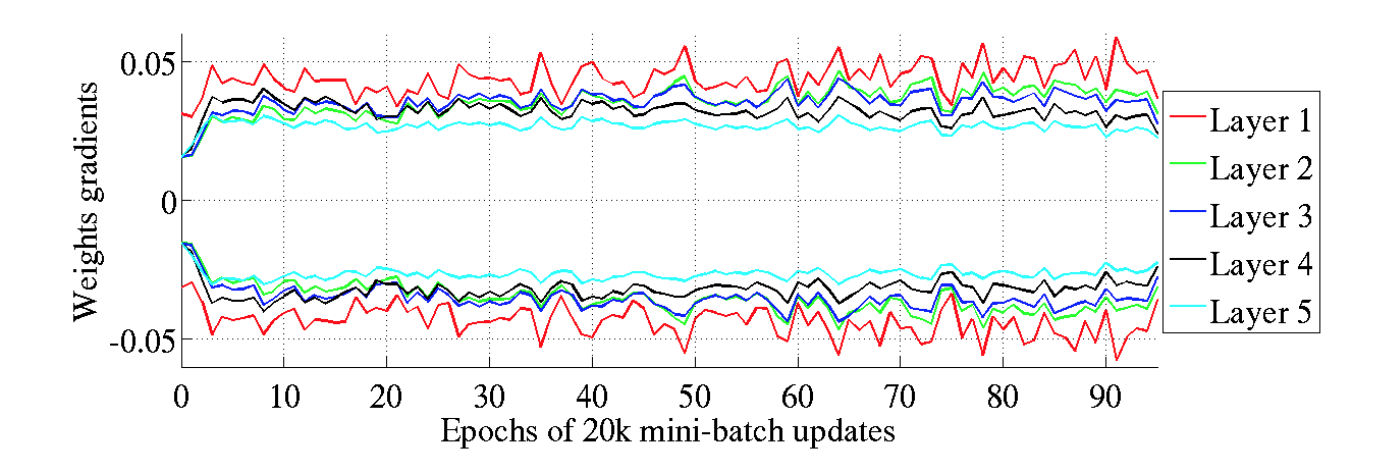

In [ ]:
def init_f(forw):
    for nam, param in forw.named_parameters():
        if 'weight' in nam:
            torch.nn.init.xavier_normal_(param) 
        else:
            param.data.fill_(0.01)

In [ ]:
do_seeds(29)
init_f(nn1)

## Funcion de Pérdida

Al ser de nuevo una clasificación, emplearemos la función NLLLoss (Negative Log Likelihood Loss). 
Para cada fila se calcula el NLLLoss como -log() de la probabilidad asignada por nuestro modelo a la _clasificación_ real correspondiente a dicha fila. La pérdida del minilote es la media de la pérdida de cada fila.


Generaremos una función para calcular la pérdida:

In [ ]:
def loss_f(x, y, forw):
    return torch.nn.functional.nll_loss(forw(x), y)

In [ ]:
loss_f(tX_train_l, ty_train, nn1) # Vemos que nos devuelve un tensor con su gradiente

## Funciones de Predicción y Scoring

Construimos una función que genere predicciones a partir del resultado de la propagación hacia adelante, y otra que evalúe el porcentaje de aciertos.  

In [ ]:
# función de predición
def pred_f(x, forw):
    with torch.no_grad():
        _, y_pred = torch.max(forw(x), dim=1) #devolverá la probabilidad más alta (de ser maligno/benigno)
    return y_pred

In [ ]:
# función de scoring
def score_f(x, y, forw):
    with torch.no_grad():
        y_pred = pred_f(x, forw)
        score = torch.sum(y_pred == y).item() / len(y) # devuelve la suma de aciertos del total de elementos
    return score

Comprobamos que la precisión de nuestra red neuronal con el cojunto de entrenamiento y el de testing es aproximadamente el 50% (es decir, predice de forma "aleatoria"). 

In [ ]:
print(score_f(tX_train_l, ty_train, nn1))
print(score_f(tX_test_l, ty_test, nn1))

## Entrenamiento con Retropropagación

Ejecutaremos el entrenamiento de la red paso a paso. En cada paso ejecutaremos el optimizador para que minimice la pérdida empleando las derivadas

In [ ]:
def t_step(x, y, forw, opt):

    # Método de Retropropagación
    opt.zero_grad() # reseteamos los valores acumulados de las derivadas para que no se acumulen
    
    loss = loss_f(x, y, forw) # calculamos la pérdida con la NLLLoss
    out = loss.item() # almacenamos el valor de la pérdida como resultado intermedio
    loss.backward() # propagamos las derivadas de la pérdida con respecto a nuestros parámetros
    opt.step() # ejecutamos un paso de nuestro optimizador
    return out

Los pasos del algoritmo *Gradient Descent* son:

<ol>
    <li>Encontrar la pendiente de la función objetivo con respecto a cada parámetro / característica. Es decir, calcular el gradiente de la función.</li>
    <li>Elegir un valor inicial aleatorio para los parámetros. Si tuviéramos características como x1, x2, etc., se toma  la derivada parcial de "y" con respecto a cada una de las características. </li>
    <li>Actualizar la función de pérdida conectando los valores de los parámetros.</li>
    <li>Calcular los tamaños de paso para cada característica como: tamaño de paso = gradiente * tasa de aprendizaje.</li>
    <li>Calcular los nuevos parámetros como: nuevos parámetros = viejos parámetros - tamaño del paso</li>
    <li>Repita los pasos 3 a 5 hasta que el gradiente sea casi 0.</li>
   
</ol>

El problema del *Gradient Descent* es cómo escala. Digamos que tenemos 10.000 puntos de datos y 10 características. La suma de los residuos al cuadrado consta de tantos términos como puntos de datos, es decir, 10.000 términos en nuestro caso. Necesitamos calcular la derivada de esta función con respecto a cada una de las características, por lo que, en efecto, haremos 10.000 * 10 = 100.000 cálculos por iteración. Es común tomar 1.000 iteraciones, en efecto, tenemos 100,000 * 1000 = 100.000.000 cálculos para completar el algoritmo. Es una fuerte carga y, por lo tanto, el descenso de gradientes es lento con *Big Data*.

El algoritmo del __Stochastic Gradient Descent (SGD)__ selecciona puntos de datos en cada paso para calcular las derivadas. SGD elige aleatoriamente un punto de datos de todo el conjunto de datos en cada iteración para reducir enormemente los cálculos. También es común muestrear una pequeña cantidad de puntos de datos en lugar de solo un punto en cada paso. Se denomina descenso de gradiente de *mini lotes*. El mini-lote intenta lograr un equilibrio entre la bondad del descenso de gradiente y la velocidad de SGD (razonablemente preciso y rápido).

Ejecutamos el SGD en nuestra red con una tasa de aprendizaje (*learning rate*) de 0,0025

In [ ]:
opt1 = torch.optim.SGD(nn1.parameters(), lr=0.0025)

Comenzamos el entrenamiento:

In [ ]:
# inicialización de pesos Xavier
do_seeds(29)
init_f(nn1)

In [ ]:
for i in range(5000):
    
    # entrenamos con retropropagación
    out = t_step(tX_train_l, ty_train, nn1, opt1)
    if i%500 == 0:
        print("Época: {}, Pérdida: {:.4f}".format(i, out))

In [ ]:
print(score_f(tX_train_l, ty_train, nn1))
print(score_f(tX_test_l, ty_test, nn1))

Podemos comprobar que, aunque nuestra red neuronal ha aprendido, el ajuste con el conjunto de test es mucho mas bajo que el ajuste con el conjunto de entrenamiento, que indica que la red está __sobreajustada__. Para ver mas claramente lo que ocurre con nuestra red, vamos a repetir el entrenamiento obteniendo la puntuación y la pérdida para el training y el testing en cada iteración de entrenamiento. 

In [ ]:
# inicialización de pesos
do_seeds(29)
init_f(nn1)

In [ ]:
# Se unen los resultados de 10.000 épocas (iteraciones) de ejecuciones de la red
# los resultados se alojan en vectores que son unidos en una sola matriz
# cada matriz contiene la información de pérdida en entrenamiento y testing, además de la evaluación en ambas
# particiones 

tr_stats = np.stack([np.array([i, t_step(tX_train_l, ty_train, nn1, opt1), loss_f(tX_test_l, ty_test, nn1).item(),
    score_f(tX_train_l, ty_train, nn1), score_f(tX_test_l, ty_test, nn1)]) for i in range(10000)], axis=0)

In [ ]:
# La matriz se aloja en un DataFrame con los nombres de las columnas
tr_stats_df = pd.DataFrame(tr_stats, columns=['Época', 'tr_loss', 'te_loss', 'tr_score', 'te_score'])

In [ ]:
print(tr_stats_df)

In [ ]:
# Dibujamos la funcion de coste que muestra el sobreajuste entre el subconjunto de entrenamiento 
# y el subconjunto de validación

ax = sns.lineplot(x='Época', y='tr_loss', data=tr_stats_df, legend='full')
sns.lineplot(x='Época', y='te_loss', data=tr_stats_df, legend='full', ax=ax)
ax.set(yscale="log")

La línea azul es la pérdida en entrenamiento que converge a medida avanzamos en el ajuste. Sin embargo, la línea naranja que representa la pérdida con el conjunto de testing se estanca en un mínimo local

In [ ]:
# Dibujamos la función de ajuste que muestra el mismo sobreajuste

sns.lineplot(x='Época', y='tr_score', data=tr_stats_df)
sns.lineplot(x='Época', y='te_score', data=tr_stats_df)

El gráfico presenta el ajuste (*scoring*). La línea azul con el conjunto de entrenamiento obtiene unos niveles de precisión elevados, mientras que la línea naranja que representa el ajuste con el conjunto de entrenamiento se estanca indicando un claro sobreajuste.

# 4. Validación del modelo. Mejora del entrenamiento

Hemos visto que a lo largo del entrenamiento la precisión con el subconjunto de entrenamiento continua aumentando mientras que la precisión obtenida con el subconjunto de testing se estanca. Esto ocurre, entre otras cosas, porque la optimización converge a un mínimo local que minimiza la pérdida del entrenamiento, y por ello no generaliza correctamente con el subconjunto de testing. Para reducir el sobreajuste (*overlearning*) vamos a utilizar dos estrategias: 

<ol>
    <li>Regularización</li>
    <li>Entrenamiento con Minilotes</li>
</ol>

## 1. Técnicas de Regularización

La regularización consiste en añadir un término en la función de pérdida de tal forma que los pesos no puedan tomar valores elevados. Este ajuste hace que la red tenga un entrenamiento distribuido homogéneamente lo cual reduce el sobreajuste. 

### L2

Esta regularización conocida como norma L2, Weight Decay (Decaimiento de los Pesos) o Ridge Regression (Regresión Contraida) consiste en añadir un término proporcional a la suma del cuadrado de los pesos. Esta regularización es equivalente a realizar una reducción ponderada de los pesos en cada iteración (método del *weight decay*). En Pytorch está implementado como parámetro en la mayoría de los algoritmos de optimización.

La idea detrás de este tipo de regularización es reducir el valor de los parámetros para que sean pequeños. Esta técnica introduce un término adicional de penalización en la función de coste original (L), añadiendo a su valor la suma de los cuadrados de los parámetros (ω).

### L1

En la regularización L1 conocida como __Lasso__ (Least Absolute Shrinkage and Selection OLperator) los parámetros en el sumatorio del término de penalización no se elevan al cuadrado, sino que se usa su valor absoluto. 

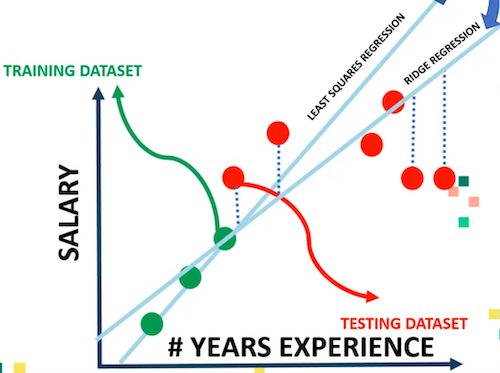

Ejecutamos el optimizador SGD con una learning rate de 0,0005 y un decaimiento de los pesos de 0,02

In [ ]:
opt2 = torch.optim.SGD(nn1.parameters(), lr=0.0005, weight_decay=0.02)

## 2. Entrenamiento con Minilotes

El entrenamiento con minilotes consiste en utilizar un número reducido de filas muestreadas del conjunto de entrenamiento en cada paso del proceso, en lugar de utilizar el juego completo. 

Cuando se recorren todas las filas del juego de datos al cabo de un cierto número de iteraciones, se vuelve a empezar (cada paso completo recorrido por el juego de datos es una __época__). Esto permite dar más pasos de optimización por cada *época*, ayudando a acelerar el entrenamiento evitando mínimos locales, reduciendo así el sobreajuste.

Construimos los minilotes así con el método DataLoader. Creamos minilotes de 100 filas que son reordenados en cada época (*shuffle*)

In [ ]:
from torch.utils import data
mini_b_l = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(tX_train_l, ty_train), 
                                       batch_size=100, shuffle=True)

In [ ]:
# inicializamos los pesos
do_seeds(29)
init_f(nn1)

In [ ]:
for i in range(500): # Entrenamos 500 épocas
    for x_j, y_j in mini_b_l: # En cada iteración, mini_b_l genera valores de 'x' y de 'y' hasta que agota la época
        out = t_step(x_j, y_j, nn1, opt2) # Se ejecuta el optimizador paso a paso pero con x_j e y_j
                                          # no con el dataset de training completo
    if i%100 == 0:
        print("Época: {}, Pérdida: {:.4f}".format(i, out))

In [ ]:
# Obtenemos el ajuste con los subconjuntos de entrenamiento y de validación

print(score_f(tX_train_l, ty_train, nn1))
print(score_f(tX_test_l, ty_test, nn1))

Vemos que ha mejorado el problema del sobreajuste, siendo las métricas de ajuste similares con los conjuntos de entrenamiento y de testing. El resultado en general no es demasiado bueno (precisión ~80% ), y el entrenamiento de esta red es caro dado el elevado número de parámetros, aún considerando que es una red de una sola capa oculta. En la siguiente sección veremos como podemos aplicar capas convolucionales específicas para el procesamiento de imágenes para reducir el número de parámetros de nuestra red y conseguir mejores tasas de acierto.

# 5. La Clasificación con Redes Neuronales Convolucionales

Hasta ahora el número de parámetros de nuestra red es muy elevado, haciendo que nuestra red tienda al sobreajuste. Esto ocurre porque, al tener una capa completamente conectada (__fully connected layer__) como capa oculta, cada valor de input de nuestra imagen se conecta con cada una de los nodos de la capa oculta, multiplicando el número de parámetros.

Para reducir el número de parámetros podemos aprovechar la información espacial que nos proporciona la disposición de los píxeles en la imagen. Podemos hacer esto utilizando capas __convolucionales__ en lugar de capas completamente conectadas, en combinación con capas __max pooling__

## 5.A ¿Qué es una Convolución?

Una convolución consiste en la aplicación de un filtro a cada pixel de una imagen, para obtener una segunda imagen. En concreto, cada pixel de la imagen resultante es la suma del producto elemento a elemento del filtro (una matriz $n\times n$) con cada sección de la imagen de entrada.


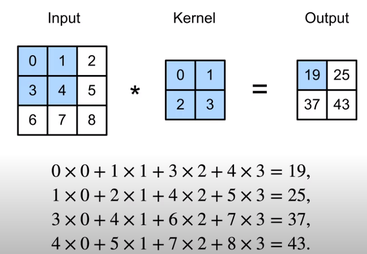




El filtro __Sobel__ calcula el gradiente de la intensidad de una imagen en cada punto (píxel). Así, para cada punto, este operador da la magnitud del mayor cambio posible, la dirección de este y el sentido desde oscuro a claro. El resultado muestra cómo de abruptamente o suavemente cambia una imagen en cada punto analizado y, en consecuencia, cuán probable es que este represente un borde en la imagen y, también, la orientación a la que tiende ese borde. En la práctica, el cálculo de la magnitud -probabilidad de un borde- es más fiable y sencillo de interpretar que el cálculo de la dirección y sentido. 

Otro filtro interesante, normalmente usado en conjunción con Sobel, es __Blur__. Este filtro obtiene medias de cada porción de la imagen (*kernel*) y así difumina las diferencias de color. Se utiliza para eliminar impurezas. Luego se aplica el filtro Sobel para detectar los bordes.

Para generar la imagen de salida, el filtro va recorriendo la imagen de entrada pixel a pixel y generando un valor. Aparte del tamaño del filtro (_kernel_) $n$, hay otros dos parámetros que podemos variar: el _stride_ (paso) y el _padding_ (relleno). El _stride_ $s$ consiste en el número de píxeles que avanzamos cada vez que movemos el filtro. El _padding_ $p$ es el número de píxeles adicionales que añadimos en los bordes de la imagen original (habitualmente rellenados con el valor cero; es decir, se prescinde de ellos) para que el filtro pueda abarcar mas puntos

La siguiente imagen muestra la aplicación de una convolución con un _kernel_ con $n=3$, un _stride_ $s=2$ y un _padding_ $p=1$.
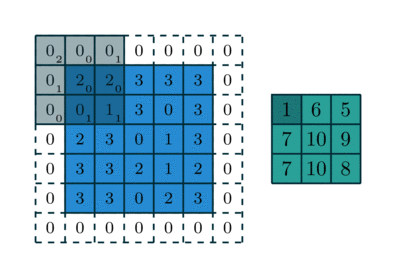
_Fuente:_ http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html

### Convoluciones en Pytorch: ejemplos

En Pytorch podemos aplicar convoluciones con el módulo __Conv2d__. Para crear un módulo Conv2d debemos proporcionar el número de canales de entrada $c$ que aceptará el filtro, el número de canales de salida que producirá y el tamaño del filtro $n$. Adicionalmente también podemos proporcionar el _stride_ $s$ y el _padding_ $p$. 

_Nota:_ Aunque cada filtro siempre devuelve una imagen con un solo canal, por conveniencia podemos especificar el número de canales de salida $c_\mathrm{out}$, de forma que se apliquen $c_\mathrm{out}$ filtros distintos y se "apilen" los resultados.

Para probar distintos filtros utilizaremos la imagen "cat2.jpg" de 1080 x 1920 x 3 colores.
Empleamos el método __skimage.io.imread(fname)__ de la librería scikit-image para cargar la imagen.

__fname__ es el nombre del fichero con la imagen y devuelve un ndarray con *img_array*  con los diferentes canales de color almacenados en la tercera dimensión, de modo que una imagen gris es MxN, una imagen RGB MxNx3 y una imagen RGBA MxNx4

In [ ]:
cat_img = io.imread('cat2.jpg')/255.0
cat_img.shape # Resolución imagen: 1080 x 1920 píxeles; 3 canales

In [ ]:
io.imshow(cat_img)

Generamos un filtro con _Conv2d_:

In [ ]:
f1 = torch.nn.Conv2d(3, 1, 5, padding=2) 

# torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, 
# bias=True, padding_mode='zeros', device=None, dtype=None)


# 3 canales de entrada (in_channels = 3), 1 canal de salida (out_channels = 1), tamaño del kernel 5 x 5 
# (kernel_size = 5), relleno de dos filas (padding = 2)

print(f1)

Vemos los parámetros que contiene el módulo Con2d empleando el método __named.parameters()__

In [ ]:
for name, param in f1.named_parameters():
    print(name, param.shape)

Vemos que al tener un filtro de $5\times 5$ y 3 canales, los valores de nuestro filtro son una matriz de $3\times 5 \times 5$. El segundo parámetro (bias) es un término constante que se añade al valor resultante de aplicar el filtro en cada pixel y también es un parámetro ajustable.

Probemos a aplicar el __filtro Sobel 5x5__ que detecta bordes verticales en la imagen. Técnicamente, es un operador de diferenciación discreto, que calcula una aproximación del gradiente de la función de intensidad de la imagen. En cada punto de la imagen, el resultado del operador de Sobel-Feldman es el vector de gradiente correspondiente o la norma de este vector. El operador Sobel-Feldman se basa en convolucionar la imagen con un filtro pequeño, separable y de valor entero en las direcciones horizontal y vertical y, por lo tanto, es relativamente económico en términos de cálculos. Por otro lado, la aproximación de gradiente que produce es relativamente burda, en particular para variaciones de alta frecuencia en la imagen.

In [ ]:
sv_5x5 = [[ -5, -4, 0,  4,  5],
          [ -8,-10, 0, 10,  8],
          [-10,-20, 0, 20, 10],
          [ -8,-10, 0, 10,  8],
          [ -5, -4, 0,  4,  5]]

In [ ]:
for name, param in f1.named_parameters():
    if name == 'weight':
        param.data[:,:,:,:] = torch.tensor([[sv_5x5]*3]) # Reemplazamos el peso por el filtro Sobel 5 x 5
    elif name == 'bias':
        param.data.fill_(0) # Reemplazamos el bias por 0

Comprobamos que ha metido el filtro Sobel como parámetros (nuevos pesos y nuevos sesgos)

In [ ]:
for name, param in f1.named_parameters():
    print(param.data)

Antes de aplicar el filtro tenemos que crear un tensor de Pytorch con la imagen. Adicionalmente tenemos que reorganizar el orden de las dimensiones, ya que los módulos _Conv2d_ esperan tensores de la forma [m_ejemplos, c_canales, h_altura, w_anchura].

El método __np.transpose()__ de NumPy reorganiza las dimensiones. 
El método __unsqueeze()__ de Pytorch  añade la dimensión extra al principio (m_ejemplos). Devuelve un nuevo tensor con una dimensión de tamaño uno insertado en la posición especificada. El tensor devuelto comparte los mismos datos subyacentes con este tensor.

In [ ]:
# cat_img es el tensor 1080 x 1920 x 3 con la imagen
# np.transpose transpone el tensor la primera dimension será la anterior última (2), la segunda será la anterior
# primera y la tercera será la anterior segunda

t_cat_image = torch.tensor(np.transpose(cat_img,(2,0,1)), requires_grad=False, dtype=torch.float).unsqueeze(0) 
t_cat_image.shape
# shape devuelve (1, canales color, altura, anchura)

Finalmente podemos aplicar el filtro.

In [ ]:
filt_cat = f1(t_cat_image)
filt_cat.shape

Para obtener el tensor con la imagen filtrada hacemos lo siguiente:

Obtenemos el tensor de la imagen filtrada con tensor.detach(),
Lo pasamos a ndarray con Tensor.numpy() → numpy.ndarray, de dimensión (1 x 1 x 1080 x 1920)
Usamos torch.squeeze() → Tensor para eliminar las dimensiones de 1 elemento

El resultado es una imagen filtrada con operador Sobel de 1080 x 1920

In [ ]:
print(filt_cat.detach().numpy().shape)
print(filt_cat.detach().numpy().squeeze().shape)

Observamos que la imagen resultante detecta los bordes en el eje vertical

In [ ]:
io.imshow(filt_cat.detach().numpy().squeeze())

Probamos también la detección de bordes horizontal. Para ello simplemente transponemos el filtro Sobel

In [ ]:
sh_5x5 = np.array(sv_5x5).T
for name, param in f1.named_parameters():
    if name == 'weight':
        param.data[:,:,:,:] = torch.tensor([[sh_5x5]*3])
io.imshow(f1(t_cat_image).detach().numpy().squeeze())

Por último, probamos el filtro __Blur__ que obtiene el mismo valor para todo el kernel y produce una imagen suavizada (borrosa)

In [ ]:
sh_5x5 = np.array(sv_5x5).T
for name, param in f1.named_parameters():
    if name == 'weight':
        param.data[:,:,:,:] = torch.ones_like(param.data)/(3*5*5)
io.imshow(f1(t_cat_image).detach().numpy().squeeze())

In [ ]:
for name, param in f1.named_parameters():
    print(param.data)

En el contexto de la red neuronal, en lugar de utilizar valores predefinidos en el filtro, los valores de los filtros son parámetros entrenables de la capa convolucional que se entrenan de la misma forma que los de las otras capas.

## 5.B Compresión de Imágenes. El método _Max Pooling_

El _max pooling_ es un método de reducción del número de píxeles de una imagen que consiste en escoger el valor máximo del pixel de cada región $n\times n$ de la imagen. Será como comprimir la resolución, "pixelar". Al igual que las convoluciones, también podemos jugar con el _padding_ y el _stride_.

Ejemplo: max pooling de $2\times 2$ con _stride_ 2 y _padding_ 0.

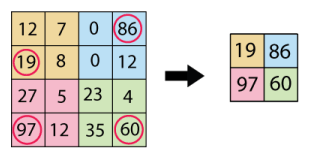

In [ ]:
mp1 = torch.nn.MaxPool2d(10) 
# el único parámetro obligatorio es n (kernel size), por defecto stride = kernel_size

In [ ]:
pool_cat = mp1(t_cat_image)
pool_cat.shape # el max pooling se aplica a cada canal por separado

In [ ]:
io.imshow(np.transpose(pool_cat.detach().numpy().squeeze(), (1,2,0)))

_Nota:_ las capas _max pooling_ no tienen parámetros entrenables.

In [ ]:
for name, param in mp1.named_parameters():
    print(name, param.shape) # no hay ningún output

## 5.C Construcción de la Red Neuronal Convolucional

Las redes neuronales convolucionales típicamente comienzan con una serie de capas convolucionales alternadas con capas de max pooling, para terminar con una serie de capas completamente conectadas. Esto consigue reducir la dimensionalidad de la imagen con muchos menos parámetros entrenables que si fueran todas capas completamente conectadas.

Para nuestro problema de clasificación de imágenes de lesiones cutáneas utilizaremos la siguiente arquitectura:
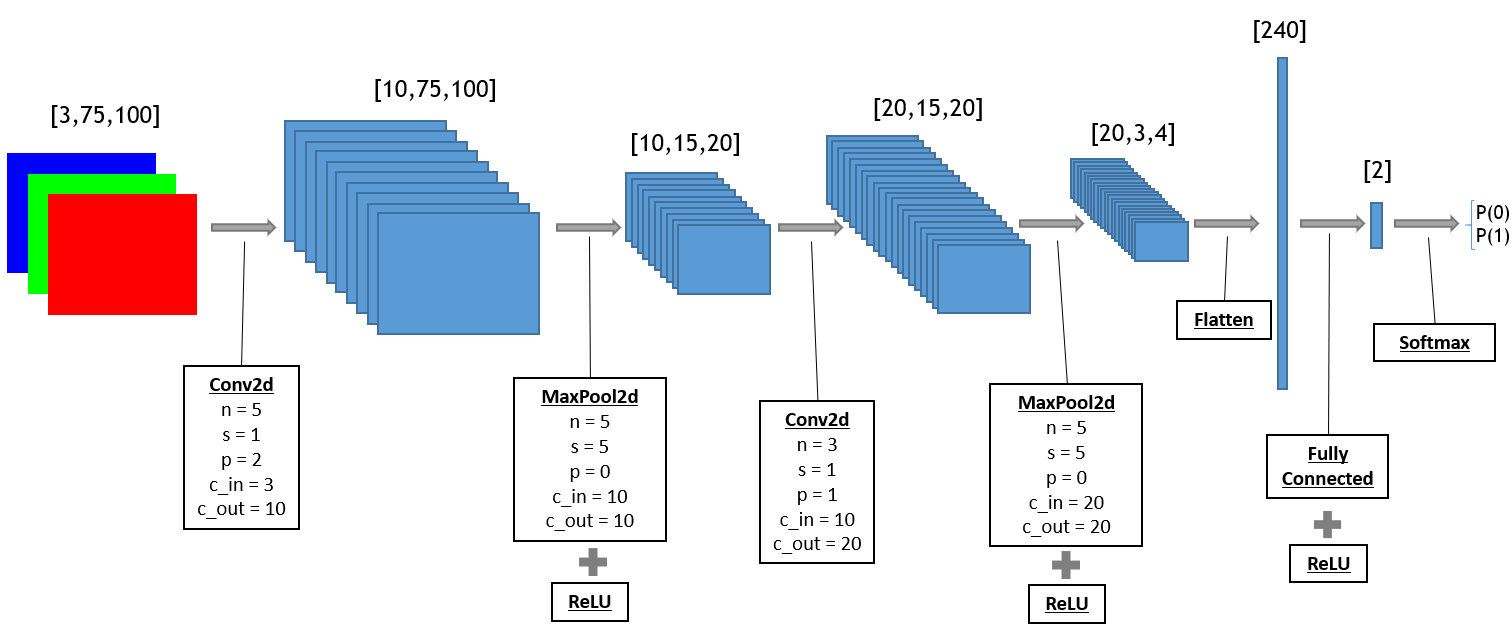

In [ ]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

<ol>
    <li>Construimos la red neuronal convolucional descrita arriba y la entrenamos con regularización y minilotes </li>
    <li>Dibujamos el ajuste y la pérdida con los conjuntos de entrenamiento y test a medida progresa la iteración del algoritmo</li>
</ol>


In [ ]:
nn2 = torch.nn.Sequential(
    torch.nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2),
    torch.nn.MaxPool2d(5),
    torch.nn.LeakyReLU(),

    torch.nn.Conv2d(10, 20, kernel_size=3, stride=1, padding=1),
    torch.nn.MaxPool2d(5),
    torch.nn.LeakyReLU(),

    Flatten(),
    torch.nn.Linear(240, 2), 
    torch.nn.LogSoftmax(dim=1) 
)

In [ ]:
print(nn2)

In [ ]:
# Movemos la carga de trabajo a la GPU
nn2 = nn2.cuda()

In [ ]:
# Comprobamos el tamaño del output de la red neuronal (1600 x2)
nn2(tX_train).shape

In [ ]:
# Número de parámetros del modelo: 3062
np.sum([np.prod(p.shape) for p in nn2.parameters()])

In [ ]:
#inicializamos los pesos
do_seeds(29)
init_f(nn2)

## Optimizador Adam (Adaptive Moment Estimation Algorithm)

Optimización basada en gradientes de primer orden de funciones objetivas estocásticas. El método es sencillo de implementar y es muy adecuado para problemas que son grandes en términos de datos y / o parámetros. 

Los resultados empíricos demuestran que Adam funciona bien en la práctica y se compara favorablemente con otros métodos de optimización estocástica

In [ ]:
# Empleamos el optimizador Adam con una tasa de aprendizahe de 0,0002 y un weight decay de 0,4  

opt3 = torch.optim.Adam(nn2.parameters(), weight_decay=0.008, lr=0.0002)

Creamos 100 minilotes con la clase __Dataloader__

In [ ]:
mini_b = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(tX_train, ty_train), 
                                       batch_size=100, shuffle=True) # shuffle: reordena el dataset en cada época

In [ ]:
# Entrenamos un bucle de 500 épocas
for i in range(500): 
    for x_j, y_j in mini_b:
        out = t_step(x_j, y_j, nn2, opt3) 
    if i%10 == 0:
        print("Época: {}, Pérdida: {:.4f}".format(i, out))

In [ ]:
print(score_f(tX_train, ty_train, nn2))
print(score_f(tX_test, ty_test, nn2))

Hemos mejorado el ajuste en el testing acercándose al ajuste de entrenamiento
Dibujamos la pérdida y la precisión en función del número de épocas

In [ ]:
# inicializamos los pesos
do_seeds(29)
init_f(nn2)

In [ ]:
# Volvemos a unir los datos de pérdida y ajuste de los juegos de entrenamiento y de testing

tr_stats2 = np.stack([np.array([i, np.mean(list(t_step(x_j, y_j, nn2, opt3) for x_j, y_j in mini_b)),
    loss_f(tX_train, ty_train, nn2).item(), loss_f(tX_test, ty_test, nn2).item(),
    score_f(tX_train, ty_train, nn2), score_f(tX_test, ty_test, nn2)]) for i in range(500)], axis=0)

In [ ]:
# Alojamos los resultados en un DataFrame

tr_stats2_df = pd.DataFrame(tr_stats2, columns=['Época', 'mean_loss', 'tr_loss', 'te_loss', 'tr_score', 'te_score'])

In [ ]:
print(tr_stats2_df)

In [ ]:
# Dibujamos un gráfico de líneas con lineplot de Seaborn
ax = sns.lineplot(x='Época', y='tr_loss', data=tr_stats2_df)
sns.lineplot(x='Época', y='te_loss', data=tr_stats2_df, ax=ax)
ax.set(yscale="log")

In [ ]:
sns.lineplot(x='Época', y='tr_score', data=tr_stats2_df)
sns.lineplot(x='Época', y='te_score', data=tr_stats2_df)

Vemos en ambos gráficos una convergencia de la pérdia y el ajuste con las particiones de entrenamiento y testing señalando que hemos eliminado el problema del sobreaprendizaje

## 5.D Visualización de los Filtros

Podemos visualizar los efectos de los filtros que ha aprendido la red neuronal. Para ello simplemente evaluamos la red entrenada con una imagen en concreto:

In [ ]:
print(ty_train[2].item())
io.imshow(np.transpose(0.5+tX_train[2,:,:,:].cpu().detach().numpy(),(1,2,0)))

Disponemos de 1.600 imágenes de resolución 75 x 100 con 3 canales de colores en el conjunto de entrenamiento. También tenemos su clasificación como tumor maligno (1) / benigno (0)

In [ ]:
tX_train.shape, ty_train.shape

La precisión con el conjunto de entrenamiento es muy elevada 

In [ ]:
score_f(tX_train[0:1,:,:,:], ty_train[0:1], nn2) 

Mostramos imágenes procesadas en las distintas capas de la red

In [ ]:
[io.imshow_collection(nn2[:ii](tX_train[0:1,:,:,:]).cpu().detach().numpy().squeeze()) for ii in range(7)]

## 5.E Predicciones con la red neuronal

In [ ]:
from skimage import transform

Cargamos una imagen de un melanocito (benigno) de nosotros mismos para evaluarla

In [ ]:
img1 = io.imread('melanocito.JPG')

In [ ]:
io.imshow(img1)

Convertimos la imagen con una resolución de 75 x 100 con 3 canales de colores para poderla evaluar con nuestra red

In [ ]:
img1_s = transform.resize(img1[1000:1700,1600:2600,:], (75,100), anti_aliasing=True, mode='constant') - 0.5
img1_s.shape

Ampliamos la imagen

In [ ]:
io.imshow(img1_s + 0.5)

Creamos la imagena para evaluación

In [ ]:
img1_st = torch.tensor(np.transpose(img1_s, (2,0,1)), dtype=torch.float).unsqueeze(0)
img1_st.shape

Evaluamos la imagen con nuestra red

In [ ]:
np.exp(nn2(img1_st.cuda()).cpu().detach().numpy()) 

Resultado: 94,77% que tenga el valor 0 (benigno) y 5,22% que tenga el valor 1 (maligno)

Procedemos a evaluar ahora otra imagen

In [ ]:
img2 = io.imread('lunar.jpeg')

In [ ]:
io.imshow(img2)

In [ ]:
img2_s = transform.resize(img2, (75,100), anti_aliasing=True, mode='constant') - 0.5
img2_s.shape

In [ ]:
io.imshow(img2_s+0.5)

In [ ]:
img2_st = torch.tensor(np.transpose(img2_s, (2,0,1)), dtype=torch.float).unsqueeze(0)
img2_st.shape

In [ ]:
np.exp(nn2(img2_st.cuda()).cpu().detach().numpy()) 

67,13% benigno y 32,86% maligno